In [1]:
# ! pip install pesummary --no-warn-script-location

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pesummary.core.plots.bounded_1d_kde import bounded_1d_kde, TransformBoundedKDE
from pesummary.gw.plots.bounds import default_bounds
from scipy import stats

import tensorflow as tf
import tensorflow_probability as tfp
import gpflow
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from uncertainties import unumpy

from gp4gw.density.bounded_model import BoundedDensityModel
from gp4gw.density.data_preparation import *
from gp4gw.density.training_tools import *

In [3]:
%matplotlib inline

In [4]:
np.random.seed(12345)

# Define non-smooth parameter

In [5]:
inv_gamma = stats.invgamma(a=2)
samples_inv_gamma = inv_gamma.rvs(10000)

xlow = 0.0
xhigh = 0.75

transf_1 = samples_inv_gamma[samples_inv_gamma < xhigh]
transf = transf_1[transf_1 > xlow]

In [6]:
xsmooth = np.linspace(xlow, xhigh, 200, endpoint=True)
true = inv_gamma.pdf(xsmooth)
normed_true = true / (true * np.diff(xsmooth)[0]).sum()

# Select optimal binning

In [7]:
bin_vals = np.histogram_bin_edges(transf, 40)

# Interpolate density with KDEs for comparison

In [8]:
gauss_kde_scott = stats.gaussian_kde(transf, bw_method="scott")
gauss_kde_silverman = stats.gaussian_kde(transf, bw_method="silverman")

reflection = bounded_1d_kde(transf, xlow=xlow, xhigh=xhigh, method="Reflection")
transform = bounded_1d_kde(transf, xlow=xlow, xhigh=xhigh, method="Transform")

# Setting up histogram and scale data

In [9]:
counts, bins = np.histogram(transf, density=True, bins=bin_vals)
centroid_array = np.array(centroid_calc(bins))
print(f"Your GP will be trained on {centroid_array.shape[0]} points")

Your GP will be trained on 40 points


In [10]:
x = centroid_array.reshape(-1, 1)
y = counts.flatten()

In [11]:
x_scaled, y_scaled, x_scaler, y_scaler = scale_data(x, y)

X = tf.convert_to_tensor(x_scaled, dtype=tf.float64)
Y = tf.convert_to_tensor(y_scaled.reshape(-1, 1), dtype=tf.float64)

Shape of x-data: N=40, Q=1


In [12]:
prior_ranges = {
    "x": tfp.distributions.Uniform(transf.min(), transf.max()),
}

# Setup GP model
* add noise error from histogram to the GP likelihood
* define kernel

In [13]:
dens_std, dens_std_unscaled = calc_hist_errors(np.array(transf), bin_vals, y_scaler)

In [14]:
var = (dens_std + 1.1 * 10 ** - 6) ** 2

In [15]:
Y_data = np.hstack([Y, tf.reshape(var, (-1, 1))])

In [16]:
likelihood = HeteroskedasticGaussian()
kernel = gpflow.kernels.RBF(lengthscales=0.1, variance=1.0)

model = gpflow.models.VGP(
    (X, Y_data),
    kernel=kernel,
    likelihood=likelihood,
    num_latent_gps=1,
    mean_function=gpflow.mean_functions.Constant(y_scaler.transform(np.zeros((1, 1)))),  # we set the mean GP to be zero probability dnsity
)

# Build GP model

In [17]:
natgrad = gpflow.optimizers.NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.1)

Epoch 10: LOSS (train) 26.447573613698992
Epoch 20: LOSS (train) 10.21333840713394
Epoch 30: LOSS (train) 7.785800647759986
Epoch 40: LOSS (train) 6.943711212525496
Epoch 50: LOSS (train) 6.761408920184259
Epoch 60: LOSS (train) 6.618485337568773
Epoch 70: LOSS (train) 6.597564723956058
Epoch 80: LOSS (train) 6.547253408295042
Epoch 90: LOSS (train) 6.540313316357842
Epoch 100: LOSS (train) 6.535959788616369


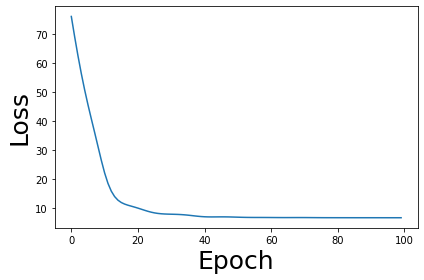

In [18]:
train_exact_heteroskedastic(model, adam, natgrad, 100)

In [19]:
density_model = BoundedDensityModel(
    likelihood=model.predict_f,
    param_names=["x"],
    priors=prior_ranges,
    parameters_scaler=x_scaler,
    y_scaler=y_scaler,
)

# Compare GP model to KDEs

In [20]:
x_new = np.linspace(xlow - 0.1, xhigh + 0.1, 200, endpoint=True)
x_new_copy = x_new.copy()
x_new_scaled = x_scaler.transform(x_new_copy.reshape(-1, 1))

In [21]:
mu, kappa = density_model.predict(x_new_scaled)

In [22]:
mean_plus_err = mu.flatten() + 2 * np.sqrt(kappa.flatten())
mean_minus_err = mu.flatten() - 2 * np.sqrt(kappa.flatten())

2021-03-12  16:55:45 PESummary INFO    : Removing 42 samples as they are outside of the allowed domain


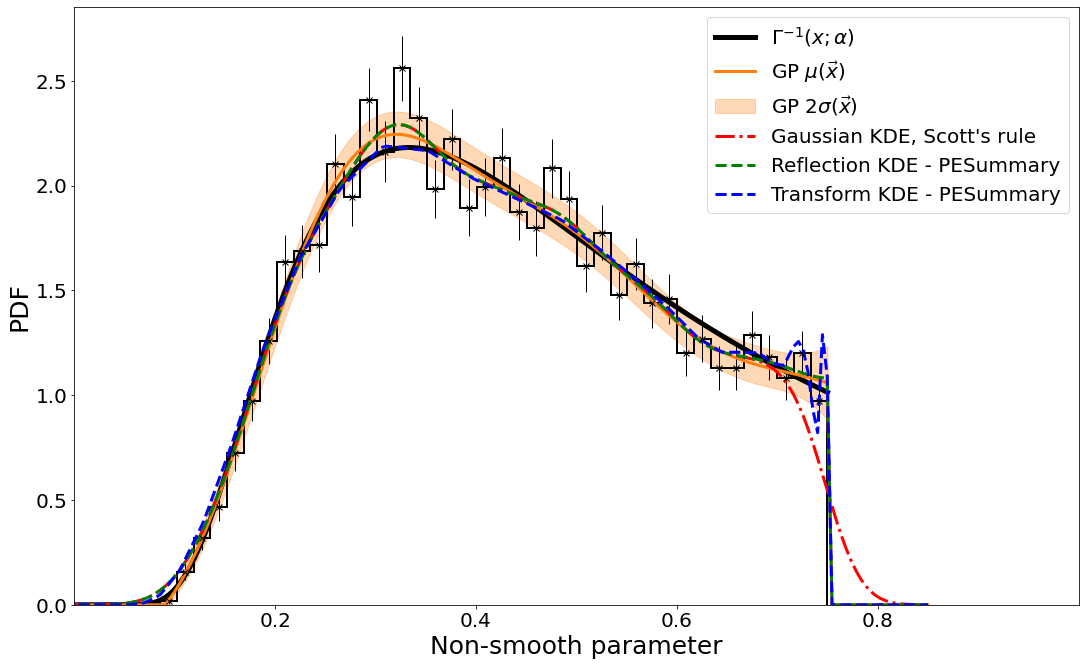

In [23]:
plt.figure(figsize=(18, 11))

plt.hist(
    transf,
    density=True,
    bins=bin_vals,
    histtype="step",
    linewidth=2,
    color="black",
)

plt.plot(
    xsmooth,
    normed_true,
    "k",
    linewidth=5,
    label=r"$ \Gamma^{-1}(x;\alpha)$",
)

plt.plot(
    x_new,
    y_scaler.inverse_transform(mu),
    "C01",
    linewidth=3,
    label=r"GP $\mu(\vec{x})$",
)

plt.fill_between(
    x_new,
    y_scaler.inverse_transform(mean_plus_err).flatten(),
    y_scaler.inverse_transform(mean_minus_err).flatten(),
    color="C01",
    alpha=0.3,
    label=r"GP $2\sigma(\vec{x})$",
)

plt.errorbar(
    x_scaler.inverse_transform(X),
    y_scaler.inverse_transform(Y),
    yerr=(dens_std_unscaled),
    marker="x",
    lw=0,
    elinewidth=1.0,
    color="k",
)

plt.plot(
    x_new,
    gauss_kde_scott(x_new),
    color="red",
    linewidth=3,
    linestyle="-.",
    label=r"Gaussian KDE, Scott's rule",
)

plt.plot(
    x_new,
    reflection(x_new),
    color="green",
    linewidth=3,
    linestyle="--",
    label=r"Reflection KDE - PESummary",
)

plt.plot(
    x_new,
    transform(x_new),
    color="blue",
    linewidth=3,
    linestyle="--",
    label=r"Transform KDE - PESummary",
)

handles, labels = plt.gca().get_legend_handles_labels()
order = [
    0,
    1,
    5,
    2,
    3,
    4,
]  # 7]
plt.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    fontsize=20,
    loc="upper right",
)

plt.xticks([0.2, 0.4, 0.6, 0.8])
plt.xlim(0.0, 1.0)
plt.ylim(0.0)
plt.ylabel(r"PDF", fontsize=25)
plt.xlabel(r"Non-smooth parameter", fontsize=25)

plt.tick_params(axis="both", labelsize=20)
# plt.savefig("1d_kde.png", dpi=100)